# B1 QQP

Primero obtuvimos los datos del portal de Profeco.

In [ ]:
# import os
# import wget
# import zipfile

# if not os.path.exists('qqp.zip') or not os.path.exists('qqp.csv'):
#     wget.download(
#        'https://drive.google.com/uc?export=download&id=0B-4W2dww7ELNazFfOFVhNG5vckE',
#         'qqp.zip'
#     )

# if not os.path.exists('qqp.csv'):
#     zipfile.ZipFile('qqp.zip').extractall()
#     os.rename('all_data.csv','qqp.csv') 

El archivo `csv` es enorme (~19gb), por lo que lo vamos a convertir a un formato más trabajable. Para ello, primero quisieramos ver qué contiene.

In [27]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
csv_file = 'qqp.csv'
parquet_file = 'pyspark_qqp/qqp.parquet'
chunksize = 100_000

csv_stream = pd.read_csv(csv_file, sep=',', chunksize=chunksize, low_memory=False)

In [4]:
display(
    csv_stream.get_chunk(1)
)

,producto,presentacion,marca,categoria,catalogo,precio,fechaRegistro,cadenaComercial,giro,nombreComercial,direccion,estado,municipio,latitud,longitud
0,CUADERNO FORMA ITALIANA,96 HOJAS PASTA DURA. CUADRICULA CHICA,ESTRELLA,MATERIAL ESCOLAR,UTILES ESCOLARES,25.9,2011-05-18 00:00:00.000,ABASTECEDORA LUMEN,PAPELERIAS,ABASTECEDORA LUMEN SUCURSAL VILLA COAPA,CANNES No. 6 ESQ. CANAL DE MIRAMONTES,DISTRITO FEDERAL,TLALPAN,19.29699,-99.125417


In [5]:
csv_stream.get_chunk(1).dtypes

producto            object
presentacion        object
marca               object
categoria           object
catalogo            object
precio             float64
fechaRegistro       object
cadenaComercial     object
giro                object
nombreComercial     object
direccion           object
estado              object
municipio           object
latitud            float64
longitud           float64
dtype: object

Lo vamos a pasar a `parquet`, pero con los tipos correctos.

In [6]:
for i, chunk in enumerate(csv_stream):
    tmp_chunk = chunk.copy()
    tmp_chunk.fechaRegistro = pd.to_datetime(tmp_chunk.fechaRegistro, errors='coerce')
    tmp_chunk.precio = pd.to_numeric(tmp_chunk.precio, errors='coerce')
    tmp_chunk.latitud = pd.to_numeric(tmp_chunk.latitud, errors='coerce')
    tmp_chunk.longitud = pd.to_numeric(tmp_chunk.longitud, errors='coerce')
    print('\rChunk {}'.format(i+1), end="")
    if i == 0:
        parquet_schema = pa.Table.from_pandas(df=tmp_chunk).schema
        parquet_writer = pq.ParquetWriter(parquet_file, parquet_schema, compression='snappy')
    table = pa.Table.from_pandas(tmp_chunk, schema=parquet_schema)
    parquet_writer.write_table(table)

print('\nFinished writing parquet file')
parquet_writer.close()

Chunk 626
Finished writing parquet file


Importamos `pyspark`.

In [7]:
import findspark
findspark.init('/home/radioabava/spark-3.0.0-bin-hadoop3.2/')

In [8]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext()
sqlContext = SQLContext(sc)
df = sqlContext.read.load("pyspark_qqp/qqp.parquet")

### ¿Cuántos registros hay?

In [9]:
print((df.count(), len(df.columns)))

(62530713, 15)


Observamos que hay más de 62 millones de registros.

### ¿Cuántas categorías?

In [10]:
df.select('categoria').distinct().count()

42

Hay 42 categorías de productos.

### ¿Cuántas cadenas comerciales están siendo monitoreadas?

In [11]:
df.select('cadenaComercial').distinct().count()

706

706 cadenas están siendo monitoreadas.

### ¿Cómo podrías determinar la calidad de los datos?

Lo primero que podemos observar es cuántos registros inválidos existen.

In [12]:
{ col: df.filter(df[col].isNull()).count() for col in df.columns }

{'producto': 0,
 'presentacion': 0,
 'marca': 0,
 'categoria': 887338,
 'catalogo': 228,
 'precio': 20,
 'fechaRegistro': 20,
 'cadenaComercial': 1184,
 'giro': 287,
 'nombreComercial': 0,
 'direccion': 0,
 'estado': 15054,
 'municipio': 15054,
 'latitud': 1152743,
 'longitud': 1152743}

Lo que más falta son latitudes y longitudes. Posteriormente las categorías. Una primera idea para completar los faltantes sería tomar la categoría del mismo producto en otro registro. De igual manera, por medio de la dirección, podríamos completar algunos datos de latitudes y longitudes. Sin embargo, para este ejercicio y dado que los datos faltantes representan menos del 1% del total, simplemente los eliminaremos.

In [18]:
df = df.na.drop()

In [19]:
print((df.count(), len(df.columns)))

(60502738, 15)


También podemos estudiar los precios.

In [20]:
histograma_precio = df.select('precio').rdd.flatMap(lambda x: x).histogram(11)

In [25]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

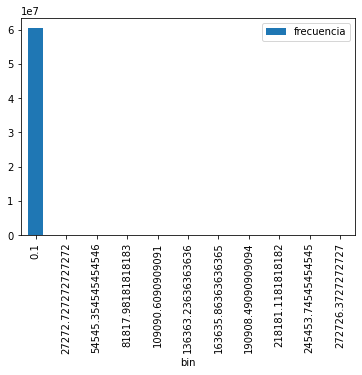

In [26]:
pd.DataFrame(
    list(zip(*histograma_precio)), 
    columns=['bin', 'frecuencia']
).set_index(
    'bin'
).plot(kind='bar')
plt.show()


Por el tipo de productos estudiados, es dudoso que haya algunos con un costo superior a los 100,000MXN